## Load Libraries

In [29]:
# import modules for data transformation
import numpy as np
import datetime as dt
import pandas as pd
# import modules for analysis
import umap.umap_ as umap
import hdbscan
import causalimpact as ci
# import modules for generating plots
from plotnine import ggplot, geom_point, geom_line, geom_density, aes, stat_smooth, ggtitle, theme_classic, xlab, ylab, facet_grid

In [36]:
home_dir='your directory here'

## Load Crash Data

In [8]:
# load crash data
crashes_df = pd.read_csv(home_dir + '/US_Accidents_Dec20.csv')
# shape
crashes_df.shape

(4232541, 49)

In [9]:
# convert start_time to datetime type
crashes_df['Start_Time'] = crashes_df.Start_Time.astype('datetime64[ns]')
# create date column
crashes_df['Start_Date'] = crashes_df.Start_Time.dt.date
# create subset of data to show to be one year prior to March 12th, 2020 and
# up to December 31st, 2020 
crashes_subset = crashes_df[ ( crashes_df['Start_Time'] > '2019-03-01' ) & ( crashes_df['Start_Time'] < '2021-01-01') ][['ID','Start_Date','County','State']]
# remove duplicates
crashes_subset = crashes_subset.drop_duplicates(subset='ID')
# remove nulls
crashes_subset = crashes_subset.dropna()
# perform the aggregation
crashes_subset = crashes_subset.groupby(['Start_Date','County','State']).agg({'ID':'count'})
crashes_subset = crashes_subset.reset_index()

## Plot of Crash Count Per Day
This shows something unexpected! there are up to 10,000 crashes per day towards the end of 2020, much higher than what appears to be a steady-state in the beginning. After some inspection, it seems that June 27th, 2020 is the beginning of a strong decrease in crashes per day. 

In [10]:
data_for_plot = crashes_subset[['Start_Date','ID']].groupby(['Start_Date']).agg({'ID' : 'sum'})
data_for_plot = data_for_plot.reset_index()
data_for_plot['index1'] = data_for_plot.index
data_for_plot.Start_Date.astype("datetime64[ns]")
data_for_plot = data_for_plot.sort_values('Start_Date')

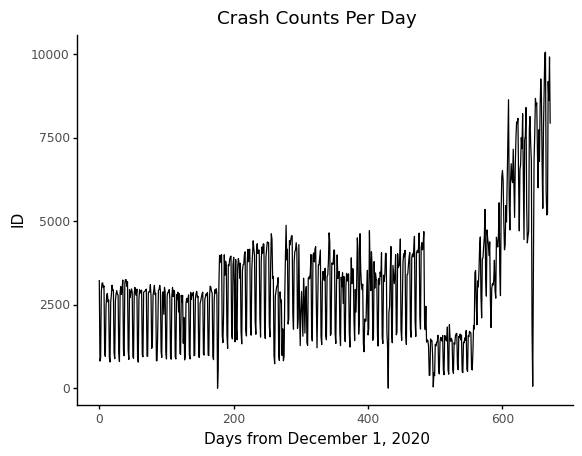

<ggplot: (8734552968765)>

In [11]:
(
    ggplot(data=data_for_plot)
    + aes('index1','ID')
    + geom_line()
    + ggtitle('Crash Counts Per Day')
    + xlab('Days from December 1, 2020')
    + theme_classic()
)

In [12]:
# show the inflection point
# the end of the pre period should really be june 29th, 2020
# the beginning of the post period should really be June 30th, 2020

In [13]:
data_for_plot[ data_for_plot['Start_Date'] == dt.date(2020,6,30)]

,Start_Date,ID,index1
487,2020-06-30,1383,487


## Unsupervised Learning with UMAP / HDBSCAN

In [14]:
data_for_cluster = crashes_subset[crashes_subset['Start_Date'] >= dt.date(2020,6,30)]
# pivot
data_pivot = data_for_cluster.pivot(index=['County','State'],columns='Start_Date',values='ID')
# fill missing
data_pivot = data_pivot.fillna(0)

In [15]:
# how to use plotnine within a function
def plot_embeddings(embeddings, scores): 
    # define dataframe for plotnine
    df = pd.DataFrame({
        'x': embeddings[:,0],
        'y': embeddings[:,1],
        'cluster': scores.labels_
    })
    # plot
    p = (
        ggplot(data=df)
        + aes('x', 'y', color='factor(cluster)')
        + geom_point()
        + ggtitle('Plot of Embeddings')
        + theme_classic()
    )
    return p

In [16]:
# convert to numpy array
np_arr = data_pivot.to_numpy()
# use UMAP to create embeddings
reducer = umap.UMAP(n_neighbors=100, random_state=100)
embeddings = reducer.fit_transform(np_arr)
# create clusters via hdbscan
hdb = hdbscan.HDBSCAN(min_cluster_size=35)
scores = hdb.fit(embeddings)

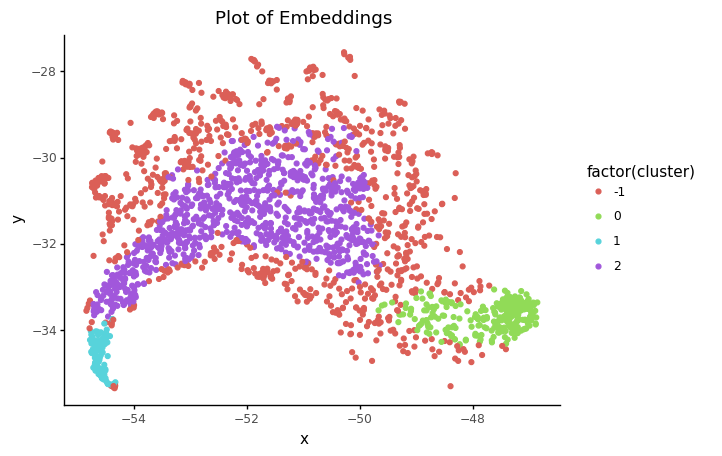

<ggplot: (8734660246001)>

In [17]:
# plot the clusters on the embeddings
plot_embeddings(embeddings, scores)
# there are 5 difference clusters 
# np.max(scores.labels_)

<AxesSubplot:ylabel='$\\lambda$ value'>

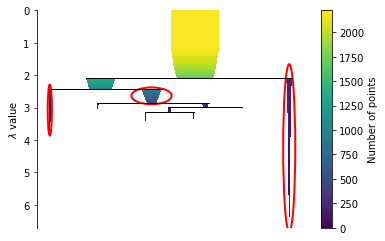

In [18]:
# plot the lambda measure
scores.condensed_tree_.plot(select_clusters=True)

In [19]:
# guess I have to reset the index first?
data_pivot = data_pivot.reset_index()
# append the clusters back to the dataframea
data_pivot['Clusters'] = scores.labels_
crashes_cluster = data_pivot.melt(id_vars=['County','State','Clusters'])
# reduce duplicates or else they will show up in the join
crashes_cluster = crashes_cluster[['County','State','Clusters']].drop_duplicates()

## Plot Clustered Counts

In [20]:
# now I have to merge the clusters back onto the full time period
data_for_plot2 = pd.merge(
    left=crashes_subset,
    right=crashes_cluster[['County','State','Clusters']],
    how="left",
    on=['County','State']
)

In [21]:
# data for plot
# data_for_plot2 = data_for_plot2[data_for_plot2['Clusters'] > -1].groupby(['Clusters','Start_Date']).agg({'ID':'sum'})
data_for_plot2 = data_for_plot2.groupby(['Clusters','Start_Date']).agg({'ID':'sum'})
data_for_plot2 = data_for_plot2.reset_index()
# create a day_value column which starts counting at the beginning of the period, March 1st
data_for_plot2['Min_Day'] = '2019-03-01'
data_for_plot2[['Start_Date','Min_Day']] = data_for_plot2[['Start_Date','Min_Day']].apply(pd.to_datetime)
data_for_plot2['Day_Value'] = (data_for_plot2['Start_Date'] - data_for_plot2['Min_Day']).dt.days

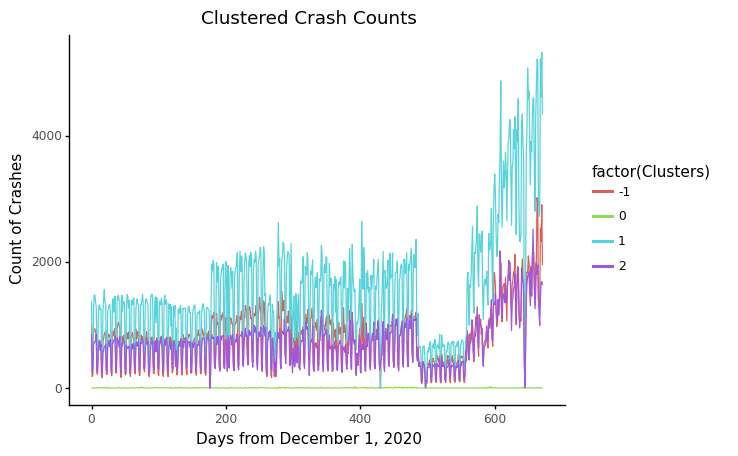

<ggplot: (8734603868705)>

In [22]:
(
    ggplot(data_for_plot2, aes('Day_Value','ID',color='factor(Clusters)'))
    + geom_line()
    + ggtitle('Clustered Crash Counts')
    + xlab('Days from December 1, 2020')
    + ylab('Count of Crashes')
    + theme_classic()
)

## Crashes By Population

https://usafacts.org/visualizations/coronavirus-covid-19-spread-map/ contains a spreadsheet of the number of residents for each county in the US. This information is loaded as a dataframe and then joined to the crash dataframe. This information is used to create my 'crashes_per_100K' metric. 

In [23]:
# load population data
pop_df = pd.read_csv(home_dir + '/covid_county_population.csv', engine='python')
# create a county variable without the word 'county'
pop_df['County'] = pop_df['County Name'].str.split(' ',expand=True)[0]
# filter out the 'statewide' category
pop_df = pop_df[ pop_df['County'] != 'Statewide']
# drop old county name column
pop_df = pop_df.drop(columns=['County Name','countyFIPS'])
# drop duplicates just in case
pop_df = pop_df.drop_duplicates()

In [24]:
cluster_pop = pd.merge(
    left=crashes_cluster,
    right=pop_df,
    how="left",
    on=['State','County']
) 

In [25]:
crashes_pop = pd.merge(
    left=crashes_subset,
    right=cluster_pop,
    how="left",
    on=['State','County']
) 

In [26]:
crashes_pop.to_csv(path_or_buf="./data_for_tableau.csv",index=False)

In [27]:
# create dataset for plot
data_for_plot3 = crashes_pop.groupby(['Clusters','Start_Date']).agg({'ID':'sum','population':'sum'})
data_for_plot3 = data_for_plot3.reset_index()
# calculate crashes per capita
data_for_plot3['crashes_per_capita'] = ( data_for_plot3['ID'] / data_for_plot3['population'] ) * 100000
# create a day_value column which starts counting at the beginning of the period, March 1st
data_for_plot3['Min_Day'] = '2019-03-01'
data_for_plot3[['Start_Date','Min_Day']] = data_for_plot3[['Start_Date','Min_Day']].apply(pd.to_datetime)
data_for_plot3['Day_Value'] = (data_for_plot3['Start_Date'] - data_for_plot3['Min_Day']).dt.days
# filter to just the 2,3 clusters
data_for_plot3 = data_for_plot3[data_for_plot3['Clusters'] > 0.0]

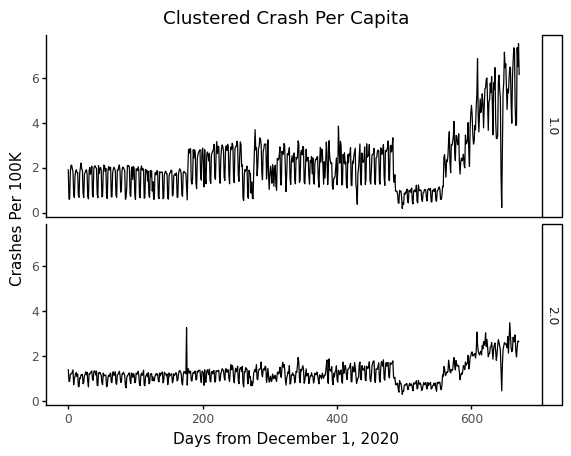

<ggplot: (8734661773741)>

In [30]:
(
    ggplot(data_for_plot3)
    + aes('Day_Value','crashes_per_capita')
    + geom_line()
    + facet_grid('Clusters ~ .')
    + ggtitle('Clustered Crash Per Capita')
    + xlab('Days from December 1, 2020')
    + ylab('Crashes Per 100K')
    + theme_classic()
)

## Plot population distribution per clusters 1, 2
Seems to be that the average population per county for Cluster 1 is larger than the average population per county for Cluster 2. This fact, in addition to the fact that counties in Cluster 1 exhibit a higher crash rate per capita, suggests that risk increases at a greater rate than can be explained by a linear relation. 

In [31]:
data_for_plot4 = cluster_pop.dropna(axis=0).copy()
data_for_plot4 = data_for_plot4[data_for_plot4['Clusters'] > 0]
data_for_plot4['poplog10'] = np.log10(data_for_plot4['population'])

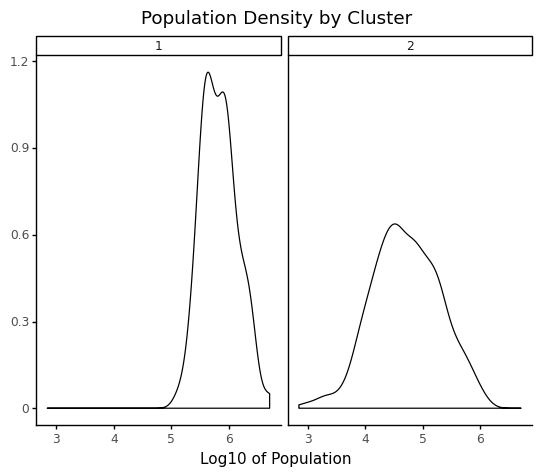

<ggplot: (8734561633877)>

In [32]:
(
    ggplot(data=data_for_plot4) 
    + aes(x='poplog10')
    + geom_density()
    + facet_grid('. ~ Clusters')
    + xlab('Log10 of Population')
    + ylab('')
    + ggtitle('Population Density by Cluster')
    + theme_classic()
)

## Filter by Cluster for Causal Impact

In [33]:
# make sure values are sorted by date
crashes_pop = crashes_pop.sort_values('Start_Date')
# filter for the appropriate cluster
data_for_cluster1 = crashes_pop[crashes_pop['Clusters'] == 1.0][['Start_Date','ID']].groupby(['Start_Date']).agg({'ID':'sum'})
data_for_cluster2 = crashes_pop[crashes_pop['Clusters'] == 2.0][['Start_Date','ID']].groupby(['Start_Date']).agg({'ID':'sum'})
# generate a 'time variable' from the index for cluster1
data_for_cluster1 = data_for_cluster1.reset_index()
data_for_cluster1['Time'] = data_for_cluster1.index
# generate a 'time variable' from the index for cluster2
data_for_cluster2 = data_for_cluster2.reset_index()
data_for_cluster2['Time'] = data_for_cluster2.index

## Causal Impact - Cluster 1

We can investigate the impact of the change in crashes by using pycausalimpact -- which is a port of the incredible causalimpact pakcage for R. It even generates a report! Here we specify everything before June 27th, 2020 as the 'pre' period and everything after ( and including ) June 27th, 2020 as the 'post' period. Note that I am using raw counts here ( not crashes per capita ) because pycausalimpact _cumulative_ effect and summing up rates is strange. Additionally, I am not including any sort of categorical variable in my analysis. 

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    2042.15            375756.0
Prediction (s.d.)         1703.38 (83.83)    313422.4 (15424.68)
95% CI                    [1544.76, 1873.36] [284235.1, 344698.72]

Absolute effect (s.d.)    338.77 (83.83)     62333.6 (15424.68)
95% CI                    [168.79, 497.4]    [31057.28, 91520.9]

Relative effect (s.d.)    19.89% (4.92%)     19.89% (4.92%)
95% CI                    [9.91%, 29.2%]     [9.91%, 29.2%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 2042.15. By contrast, in the absence of an
intervention, we would have expected an average response of 1703.38.
The 95% interval of this counterfactual prediction is [1544.76, 1873.36].
Subtracting

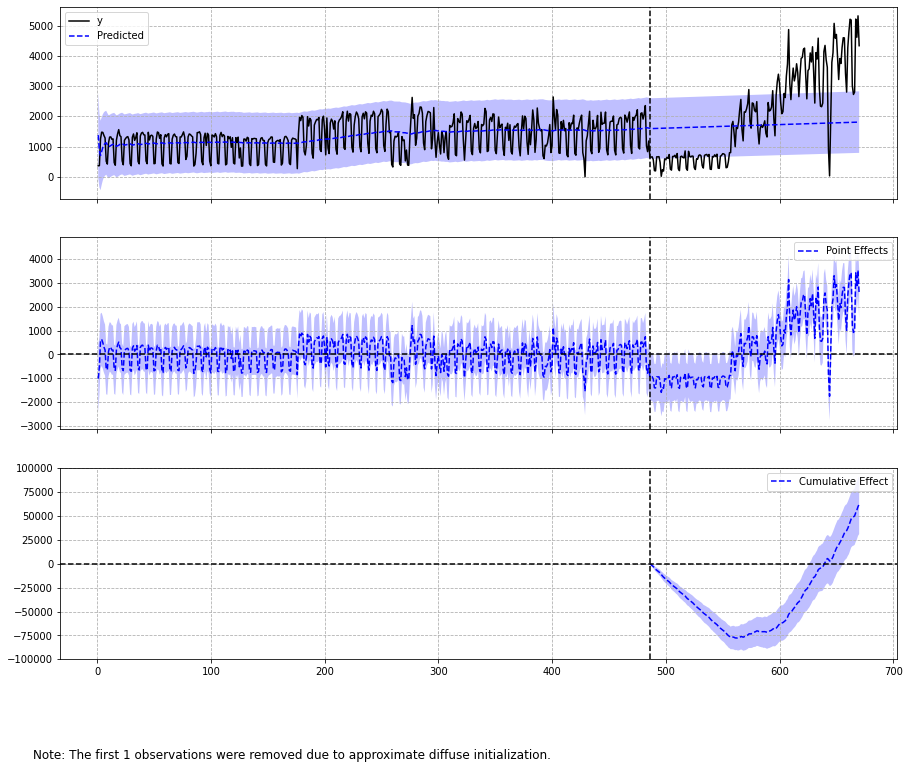

In [34]:
data = data_for_cluster1[['ID','Time']].copy()
pre_period = [0, 486]
post_period = [487, 670]

m1 = ci.CausalImpact(data, pre_period, post_period)
print(m1.summary())
print(m1.summary(output='report'))
m1.plot()

## Causal Impact - Cluster 2

We can investigate the impact of the change in crashes by using pycausalimpact -- which is a port of the incredible causalimpact pakcage for R. It even generates a report! Here we specify everything before June 27th, 2020 as the 'pre' period and everything after ( and including ) June 27th, 2020 as the 'post' period. Note that I am using raw counts here ( not crashes per capita ) because pycausalimpact _cumulative_ effect and summing up rates is strange. Additionally, I am not including any sort of categorical variable in my analysis. 

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    892.9              164293.0
Prediction (s.d.)         775.65 (40.28)     142720.37 (7411.64)
95% CI                    [698.12, 856.01]   [128453.46, 157506.57]

Absolute effect (s.d.)    117.24 (40.28)     21572.63 (7411.64)
95% CI                    [36.88, 194.78]    [6786.43, 35839.54]

Relative effect (s.d.)    15.12% (5.19%)     15.12% (5.19%)
95% CI                    [4.76%, 25.11%]    [4.76%, 25.11%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 892.9. By contrast, in the absence of an
intervention, we would have expected an average response of 775.65.
The 95% interval of this counterfactual prediction is [698.12, 856.01].
Subtracting th

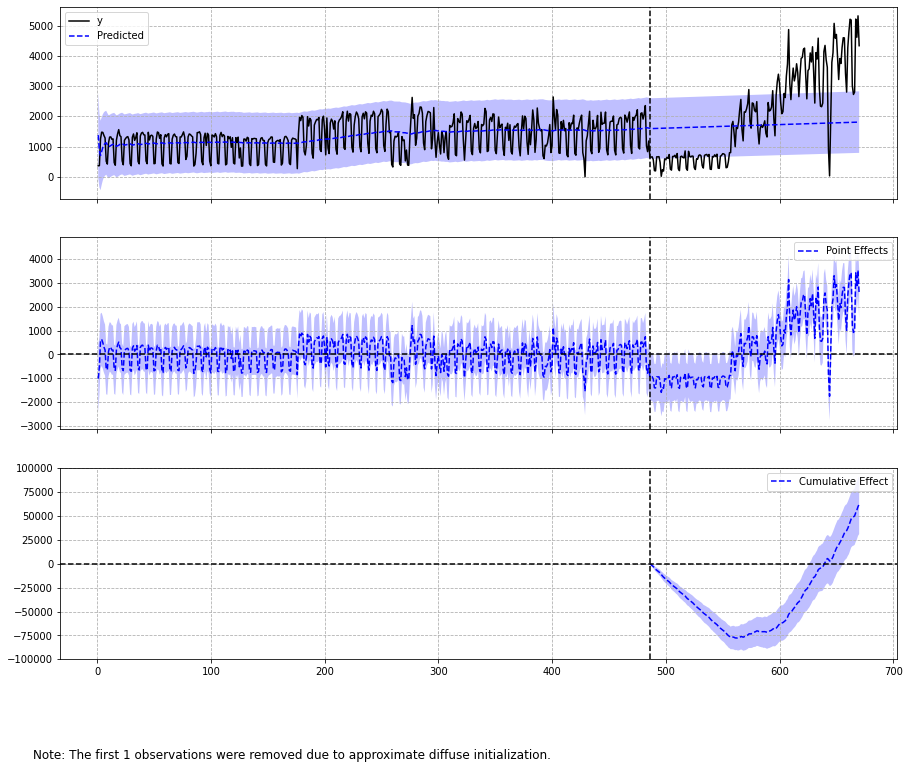

In [35]:
data = data_for_cluster2[['ID','Time']].copy()
pre_period = [0, 486]
post_period = [487, 670]

m2 = ci.CausalImpact(data, pre_period, post_period)
print(m2.summary())
print(m2.summary(output='report'))
m1.plot()